# **Introducción**
El presente notebook se desarrolló utilizando la **API-FOOTBALL v3**, una API REST que ofrece información detallada y actualizada sobre más de 1100 ligas y copas de fútbol a nivel mundial. Permite consultar resultados en vivo, alineaciones, eventos (goles, tarjetas, sustituciones), clasificaciones y estadísticas de equipos y jugadores, así como datos históricos de temporadas anteriores. Incluye filtros por fecha, liga, equipo o temporada, y el acceso se realiza mediante solicitudes HTTP autenticadas con API key.

Los datos obtenidos a través de esta API constituyen la base para las etapas posteriores de transformación y almacenamiento, siguiendo las capas Bronze–Silver en Delta Lake.

# **1. Configuración inicial**
En este paso se importan todas las librerías y funciones auxiliares definidas en `etl_utils.py`.  
Esto permite mantener el notebook limpio y modular, centralizando en un único archivo tanto las dependencias necesarias como las funciones de apoyo para el proceso ETL.

In [ ]:
# Se importa todo de etl_utils para simplificar el flujo en el notebook
from etl_utils import *

# **2. Autenticación en servicios**
La autenticación se realiza mediante las credenciales almacenadas en el archivo 
`pipeline.conf`. De esta manera, las claves necesarias (por ejemplo, Football API y 
Prefect Cloud) no quedan expuestas en el código y se facilita su manejo seguro y 
centralizado.  

**pipeline.conf**: es un archivo de configuración local en formato texto que almacena 
las credenciales y parámetros de conexión necesarios para distintos servicios. Se lee 
mediante `ConfigParser`, lo que permite construir los encabezados de autenticación sin 
exponer las claves en el código y facilita su reutilización y mantenimiento.

In [114]:
from configparser import ConfigParser

In [115]:
# Se instancia el parser y leer el archivo de configuración
parser = ConfigParser()
parser.read("pipeline.conf")

['pipeline.conf']

In [116]:
# Credenciales Football API
api_credentials = parser["api-credentials"]
headers = {"x-apisports-key": api_credentials["api_key"]}
base_url = api_credentials["base_url"]

In [117]:
base_url = "https://v3.football.api-sports.io"
response = requests.get(f"{base_url}/countries", headers=headers)

if response.status_code == 200:
    print(f"La petición fue exitosa. Se obtuvo una respuesta de tipo: {type(response.json())}")
else:
    print(f"Error en la petición: {response.status_code}, {response.content}")

La petición fue exitosa. Se obtuvo una respuesta de tipo: <class 'dict'>


In [118]:
response.json()

{'get': 'countries',
 'parameters': [],
 'errors': [],
 'results': 171,
 'paging': {'current': 1, 'total': 1},
 'response': [{'name': 'Albania',
   'code': 'AL',
   'flag': 'https://media.api-sports.io/flags/al.svg'},
  {'name': 'Algeria',
   'code': 'DZ',
   'flag': 'https://media.api-sports.io/flags/dz.svg'},
  {'name': 'Andorra',
   'code': 'AD',
   'flag': 'https://media.api-sports.io/flags/ad.svg'},
  {'name': 'Angola',
   'code': 'AO',
   'flag': 'https://media.api-sports.io/flags/ao.svg'},
  {'name': 'Antigua-And-Barbuda',
   'code': 'AG',
   'flag': 'https://media.api-sports.io/flags/ag.svg'},
  {'name': 'Argentina',
   'code': 'AR',
   'flag': 'https://media.api-sports.io/flags/ar.svg'},
  {'name': 'Armenia',
   'code': 'AM',
   'flag': 'https://media.api-sports.io/flags/am.svg'},
  {'name': 'Aruba',
   'code': 'AW',
   'flag': 'https://media.api-sports.io/flags/aw.svg'},
  {'name': 'Australia',
   'code': 'AU',
   'flag': 'https://media.api-sports.io/flags/au.svg'},
  {'name'

In [119]:
response.status_code

200

In [120]:
response.url

'https://v3.football.api-sports.io/countries'

# **3. Extracción de datos estáticos**
Se realiza una *ingesta full* para endpoints estáticos: *countries* y *leagues*.

Estos datos cambian muy poco en el tiempo, por lo que se optó por extraerlos en su totalidad en cada ejecución y sobrescribir el conjunto previo (mode="overwrite").
Esto simplifica el proceso, evita duplicados y asegura que siempre se disponga de la versión más reciente sin necesidad de rastrear cambios.

Los datos extraídos se almacenan en la capa *Bronze* en formato *Delta Lake*, sobrescribiendo en cada ejecución para asegurar consistencia y simplicidad.

In [121]:
base_url = "https://v3.football.api-sports.io"

## Primer endpoint: *countries*
El endpoint *countries* devuelve la lista de países disponibles en la API de API-Football, incluyendo su nombre, código y enlace a la bandera.
Se usa como referencia para filtrar otros endpoints (por ejemplo, ligas o equipos) según el país.

In [122]:
# Se consulta el endpoint "countries" y se obtienen los datos en formato JSON.
endpoint_1 = "countries"

In [123]:
json_data_1 = get_data(
    base_url,
    endpoint_1,
    data_field="response",
    headers=headers,
    params={}
)

In [124]:
# Se convierten a DataFrame mediante la función 'build_table'.
df_countries = build_table(json_data_1)

In [125]:
df_countries.head(3)

,name,code,flag
0,Albania,AL,https://media.api-sports.io/flags/al.svg
1,Algeria,DZ,https://media.api-sports.io/flags/dz.svg
2,Andorra,AD,https://media.api-sports.io/flags/ad.svg


## Segundo enpoint: *leagues*
El endpoint *leagues* proporciona información sobre las ligas y competiciones de fútbol en todo el mundo, incluyendo su nombre, país, tipo (liga o copa), logotipo y temporadas disponibles.
Es útil para identificar y catalogar las competiciones antes de realizar análisis o consultas más específicas.


In [126]:
# Se consulta el endpoint leagues" y se obtienen los datos en formato JSON.
endpoint_2 = "leagues"

In [127]:
json_data_2 = get_data(
    base_url,
    endpoint_2,
    data_field="response",
    headers=headers,
    params={}
)

In [128]:
# Se convierten a DataFrame mediante la función 'build_table'.
df_leagues = build_table(json_data_2)

In [129]:
df_leagues.head(3)

,seasons,league.id,league.name,league.type,league.logo,country.name,country.code,country.flag
0,"[{'year': 2008, 'start': '2008-06-07', 'end': ...",4,Euro Championship,Cup,https://media.api-sports.io/football/leagues/4...,World,None,None
1,"[{'year': 2009, 'start': '2009-06-14', 'end': ...",21,Confederations Cup,Cup,https://media.api-sports.io/football/leagues/2...,World,None,None
2,"[{'year': 2010, 'start': '2010-08-06', 'end': ...",62,Ligue 2,League,https://media.api-sports.io/football/leagues/6...,France,FR,https://media.api-sports.io/flags/fr.svg


## *Capa Bronze:* guardado en formato Delta Lake de datos estáticos
- *df_countries*
- *df_leagues*

In [130]:
# Definición de la raíz del datalake
# Se ubica dentro de la carpeta del proyecto para mantener todo centralizado.
# Usamos / para que sea portable (funciona en Windows, Linux y Mac).
datalake_root = "data/etl_datalake"

In [131]:
# Directorios de la capa Bronze
# Se crea la ruta base de Bronze para la API Football
# Contendrá los datos crudos provenientes de la API
bronze_dir = f"{datalake_root}/bronze/api_football"

In [132]:
# Subcarpetas para los datasets estáticos
# - countries_dir → almacenamiento de países
# - leagues_dir   → almacenamiento de ligas
countries_dir = f"{bronze_dir}/countries"
leagues_dir   = f"{bronze_dir}/leagues"

Se usa **mode=overwrite** en datos estáticos porque, al no cambiar con frecuencia, lo más seguro es reemplazar todo el contenido en cada actualización y así evitar duplicados o inconsistencias.

In [133]:
# countries
save_data_as_delta(df_countries, countries_dir, mode="overwrite")

In [134]:
# leagues
save_data_as_delta(df_leagues, leagues_dir, mode="overwrite")

# **4. Extracción de datos dinámicos**
Se realiza una *ingesta incremental* para el endpoint dinámico *fixtures*.
Dado que la API permite filtrar por fecha y cada extracción devuelve solo los partidos nuevos o actualizados del día, se implementó un guardado con save_new_data_as_delta usando fixture_id como clave de unicidad.
Esto preserva el histórico de ejecuciones anteriores y evita sobrescribir datos ya existentes, cumpliendo con el objetivo de registrar solo los cambios recientes.

La combinación de ambos enfoques permite optimizar el rendimiento: la ingesta full es adecuada para datos estables y de bajo volumen, mientras que la incremental es más eficiente para datos en constante actualización.

Los datos dinámicos extraídos se almacenan en la capa *Bronze* en formato *Delta Lake*, preservando histórico gracias al esquema incremental con fixture_id.

In [135]:
base_url = "https://v3.football.api-sports.io"

## Endpoint dinámico: *fixtures*
En API-Football, el endpoint *fixtures* devuelve información detallada de los partidos, incluyendo fecha, hora, equipos, marcador, estado y liga, y permite filtrarlos por parámetros como from, to, league o season. En nuestro caso, traemos sólo la fecha, pero en futuras entregas del Trabajo Integrador, es posible analizar algunas ligas específicas (como la prmier league de Inglaterra, la liga española y la Bundesliga, que son las ligas más relvantes del mundo)

In [136]:
# Fecha de ayer en formato AAAA-MM-DD
fecha_ayer = (datetime.utcnow() - timedelta(days=1)).strftime("%Y-%m-%d")
fecha_ayer

C:\Users\elias\AppData\Local\Temp\ipykernel_24732\2288028740.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  fecha_ayer = (datetime.utcnow() - timedelta(days=1)).strftime("%Y-%m-%d")


'2025-09-24'

In [137]:
endpoint_3 = "fixtures"

In [138]:
params_fixtures = {
    "date": fecha_ayer,
    "timezone": "UTC"
}

In [139]:
json_fixtures = get_data(
    base_url,
    endpoint_3,
    data_field="response",
    headers=headers,
    params=params_fixtures
)

In [140]:
df_fixtures = build_table(json_fixtures)

In [141]:
df_fixtures.head(3)

,fixture.id,fixture.referee,fixture.timezone,fixture.date,fixture.timestamp,fixture.periods.first,fixture.periods.second,fixture.venue.id,fixture.venue.name,fixture.venue.city,fixture.status.long,fixture.status.short,fixture.status.elapsed,fixture.status.extra,league.id,league.name,league.country,league.logo,league.flag,league.season,league.round,league.standings,teams.home.id,teams.home.name,teams.home.logo,teams.home.winner,teams.away.id,teams.away.name,teams.away.logo,teams.away.winner,goals.home,goals.away,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,score.extratime.home,score.extratime.away,score.penalty.home,score.penalty.away
0,1438842,Sergio Rozenhaut,UTC,2025-09-24T00:00:00+00:00,1758672000,1.758672e+09,1.758676e+09,3905.0,Hasely Crawford Stadium,Port of Spain,Match Finished,FT,90.0,6.0,856,CONCACAF Caribbean Club Championship,World,https://media.api-sports.io/football/leagues/8...,None,2025,Group Stage - 4,False,8005,Central,https://media.api-sports.io/football/teams/800...,False,3442,Mount Pleasant Academy,https://media.api-sports.io/football/teams/344...,True,0.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN
1,1438843,Reginald Gumbs,UTC,2025-09-24T00:00:00+00:00,1758672000,1.758672e+09,1.758676e+09,22458.0,Estadio Cibao,Santiago De Los Caballeros,Match Finished,FT,90.0,NaN,856,CONCACAF Caribbean Club Championship,World,https://media.api-sports.io/football/leagues/8...,None,2025,Group Stage - 4,False,4446,Juventus,https://media.api-sports.io/football/teams/444...,False,8004,Cibao,https://media.api-sports.io/football/teams/800...,True,0.0,3.0,0.0,2.0,0.0,3.0,NaN,NaN,NaN,NaN
2,1441147,None,UTC,2025-09-24T00:00:00+00:00,1758672000,NaN,NaN,NaN,None,None,Match Postponed,PST,NaN,NaN,243,Liga Pro Serie B,Ecuador,https://media.api-sports.io/football/leagues/2...,https://media.api-sports.io/flags/ec.svg,2025,Relegation Round - 5,True,1983,Imbabura,https://media.api-sports.io/football/teams/198...,None,25736,22 de Julio,https://media.api-sports.io/football/teams/257...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
# Se renombra la columna para reemplazar 'fixture.id' por 'fixture_id'.
# Esto evita problemas de sintaxis con el punto en el nombre de la columna
# y permite usarla de forma más clara y consistente en el MERGE.
df_fixtures = df_fixtures.rename(columns={"fixture.id": "fixture_id"})

### *Capa Bronze: guardado en formato Delta Lake de datos dinámicos*
Se almacenan en la capa *Bronze* los datos crudos obtenidos desde la API-Football, sin aplicar transformaciones profundas.  
De esta forma, se conserva una copia fiel de la fuente original como punto de partida para los procesos de limpieza y normalización posteriores.  
La verificación posterior confirma la correcta ingesta y particionado por fecha del dataset.

In [143]:
# Carpeta Bronze
bronze_dir = f"{datalake_root}/bronze/api_football"

In [144]:
# Subcarpeta para almacenar los fixtures en Bronze
# Se guarda la información de partidos (fixtures) tal como viene de la API.
fixtures_dir = f"{bronze_dir}/fixtures"

In [145]:
# # Se convierte la columna fixture.date a tipo datetime.
# # Luego se crea una nueva columna, "event_date", que contiene solo la fecha con año, mes y día.
df_fixtures["fixture.date"] = pd.to_datetime(df_fixtures["fixture.date"])
df_fixtures["event_date"] = df_fixtures["fixture.date"].dt.date
df_fixtures.head(3)

,fixture_id,fixture.referee,fixture.timezone,fixture.date,fixture.timestamp,fixture.periods.first,fixture.periods.second,fixture.venue.id,fixture.venue.name,fixture.venue.city,fixture.status.long,fixture.status.short,fixture.status.elapsed,fixture.status.extra,league.id,league.name,league.country,league.logo,league.flag,league.season,league.round,league.standings,teams.home.id,teams.home.name,teams.home.logo,teams.home.winner,teams.away.id,teams.away.name,teams.away.logo,teams.away.winner,goals.home,goals.away,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,score.extratime.home,score.extratime.away,score.penalty.home,score.penalty.away,event_date
0,1438842,Sergio Rozenhaut,UTC,2025-09-24 00:00:00+00:00,1758672000,1.758672e+09,1.758676e+09,3905.0,Hasely Crawford Stadium,Port of Spain,Match Finished,FT,90.0,6.0,856,CONCACAF Caribbean Club Championship,World,https://media.api-sports.io/football/leagues/8...,None,2025,Group Stage - 4,False,8005,Central,https://media.api-sports.io/football/teams/800...,False,3442,Mount Pleasant Academy,https://media.api-sports.io/football/teams/344...,True,0.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,2025-09-24
1,1438843,Reginald Gumbs,UTC,2025-09-24 00:00:00+00:00,1758672000,1.758672e+09,1.758676e+09,22458.0,Estadio Cibao,Santiago De Los Caballeros,Match Finished,FT,90.0,NaN,856,CONCACAF Caribbean Club Championship,World,https://media.api-sports.io/football/leagues/8...,None,2025,Group Stage - 4,False,4446,Juventus,https://media.api-sports.io/football/teams/444...,False,8004,Cibao,https://media.api-sports.io/football/teams/800...,True,0.0,3.0,0.0,2.0,0.0,3.0,NaN,NaN,NaN,NaN,2025-09-24
2,1441147,None,UTC,2025-09-24 00:00:00+00:00,1758672000,NaN,NaN,NaN,None,None,Match Postponed,PST,NaN,NaN,243,Liga Pro Serie B,Ecuador,https://media.api-sports.io/football/leagues/2...,https://media.api-sports.io/flags/ec.svg,2025,Relegation Round - 5,True,1983,Imbabura,https://media.api-sports.io/football/teams/198...,None,25736,22 de Julio,https://media.api-sports.io/football/teams/257...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-24


In [146]:
# Algunas columnas pueden venir vacías (None) según el torneo.
# Si Spark las infiere como NullType, no se pueden guardar en Delta.
# Se convierten a float para mantener consistencia con las demás columnas de resultados,
# ya que la API devuelve goles y marcadores en este tipo de dato.
# De esta forma se preserva la estructura, se evita el NullType y se garantiza
# un guardado correcto en la capa Bronze sin alterar la semántica original.
cols_to_float = [
    'score.extratime.home',
    'score.extratime.away',
    'score.penalty.home',
    'score.penalty.away'
]

df_fixtures[cols_to_float] = df_fixtures[cols_to_float].astype("float")

Se utiliza **fixture_id** en el predicado del MERGE porque es el identificador único que la API asigna a cada partido. Esto asegura que cada registro corresponda a un único fixture dentro de la tabla Delta y que el proceso de ingesta incremental pueda ejecutarse sin duplicar datos ya existentes.

Además, fixture_id fue diseñado en la propia API para garantizar la unicidad de cada partido, independientemente de la liga, la temporada o los equipos. De modo que se convierte en la opción más simple, confiable y robusta para identificar los encuentros en el proceso de almacenamiento incremental, asegurando consistencia en el histórico de datos.

In [147]:
# Se guarda en bronze/fixtures particionado por fecha
# Usamos fixture_id como clave única para el MERGE,
# evitando problemas de sintaxis y asegurando la unicidad de cada partido.
save_new_data_as_delta(
    df_fixtures,
    fixtures_dir,
    "target.fixture_id = source.fixture_id",
    partition_cols=["event_date"]
)

# **5. Transformaciones**
En esta sección se aplican transformaciones sobre los DataFrames obtenidos de la API.
Se renombraron columnas para mejorar la legibilidad, se crearon nuevas variables (como match_winner), se cambiaron tipos de datos para optimizar memoria y consistencia, y se eliminaron atributos redundantes o poco relevantes.

Los datos resultantes de este proceso se almacenan en la capa *Silver* en formato *Delta Lake*, ya listos para análisis ulteriores o una eventual capa *Gold*.

## *5.1 Transformaciones de datos estáticos: df_leagues*
Se trabaja con el DataFrame *df_leagues*, que contiene información sobre las ligas y competiciones de fútbol en todo el mundo, incluyendo su nombre, país, tipo (liga o copa), logotipo y temporadas disponibles.

In [148]:
# Leer Bronze (Delta)
dt_leagues = DeltaTable(leagues_dir)

In [149]:
# Se convierte a Pandas para trabajar en las transformaciones
df_leagues_bronze = dt_leagues.to_pandas()

In [150]:
# Se crea una copia para aplicar las transformaciones 
df_leagues_cleaned = df_leagues_bronze.copy()

In [151]:
# Vista rápida 
df_leagues_cleaned.head(3)

,seasons,league.id,league.name,league.type,league.logo,country.name,country.code,country.flag
0,"[{'coverage': {'fixtures': {'events': True, 'l...",4,Euro Championship,Cup,https://media.api-sports.io/football/leagues/4...,World,None,None
1,"[{'coverage': {'fixtures': {'events': True, 'l...",21,Confederations Cup,Cup,https://media.api-sports.io/football/leagues/2...,World,None,None
2,"[{'coverage': {'fixtures': {'events': True, 'l...",62,Ligue 2,League,https://media.api-sports.io/football/leagues/6...,France,FR,https://media.api-sports.io/flags/fr.svg


In [152]:
# Se renombran las columnas: se reemplazan los puntos (.) por guiones bajos (_)
# para evitar problemas de sintaxis y unificar el formato.
df_leagues_cleaned = df_leagues.rename(
                        columns = lambda columna: columna.lower().replace(".", "_"),
                        )

# Vista preliminar de los cambios
df_leagues_cleaned.head(3)

,seasons,league_id,league_name,league_type,league_logo,country_name,country_code,country_flag
0,"[{'year': 2008, 'start': '2008-06-07', 'end': ...",4,Euro Championship,Cup,https://media.api-sports.io/football/leagues/4...,World,None,None
1,"[{'year': 2009, 'start': '2009-06-14', 'end': ...",21,Confederations Cup,Cup,https://media.api-sports.io/football/leagues/2...,World,None,None
2,"[{'year': 2010, 'start': '2010-08-06', 'end': ...",62,Ligue 2,League,https://media.api-sports.io/football/leagues/6...,France,FR,https://media.api-sports.io/flags/fr.svg


In [153]:
# Se realiza el conteo de la cantidad de valores nulos en el campo league_id
print(f'Valores nulos en la columna league_id:', df_leagues_cleaned["league_id"].isnull().sum())

Valores nulos en la columna league_id: 0


In [154]:
# Se verifica que la columna 'seasons' contiene listas de diccionarios.
# Aquí se muestra solo el primer diccionario como ejemplo
df_leagues_cleaned["seasons"].iloc[0][0]

{'year': 2008,
 'start': '2008-06-07',
 'end': '2008-06-29',
 'current': False,
 'coverage': {'fixtures': {'events': True,
   'lineups': True,
   'statistics_fixtures': False,
   'statistics_players': False},
  'standings': False,
  'players': True,
  'top_scorers': True,
  'top_assists': True,
  'top_cards': True,
  'injuries': False,
  'predictions': True,
  'odds': False}}

In [155]:
# La columna 'seasons' almacena listas de diccionarios con todas las temporadas de cada liga.
# Este formato no es práctico para el análisis, ya que mezcla estructuras anidadas en una sola celda.
# Para simplificar y hacer el DataFrame más manejable, se extraen tres valores clave:
#   - min_year: primer año con datos
#   - max_year: último año con datos
#   - current_year: temporada actual
# Finalmente, se elimina la columna original 'seasons', dejando solo datos atómicos y más útiles.

In [156]:
 # min_year (primer año con datos)
# Se extrae el primer año disponible en cada liga desde la columna 'seasons'
df_leagues_cleaned["min_year"] = df_leagues_cleaned["seasons"].apply(
    lambda temporadas: min(t["year"] for t in temporadas)
)

In [157]:
# max_year (último año con datos)
# Se extrae el último año disponible en cada liga desde la columna 'seasons'
df_leagues_cleaned["max_year"] = df_leagues_cleaned["seasons"].apply(
    lambda temporadas: max(t["year"] for t in temporadas)
)

In [158]:
# Se crea la columna 'current_year'
# A partir de la columna 'seasons' se busca la temporada con current=True.
# De esa temporada se extrae el campo 'year' y se asigna a la nueva columna 'current_year'.
# Esta variable es distinta de 'max_year':
#   - 'max_year' indica el último año registrado en la historia de la liga.
#   - 'current_year' señala el año de la temporada que la API considera vigente en este momento.
# De este modo, se puede diferenciar entre la última temporada registrada y la temporada activa
df_leagues_cleaned["current_year"] = df_leagues_cleaned["seasons"].apply(
    lambda temporadas: next((t["year"] for t in temporadas if t["current"]), None)
)

In [159]:
# Se verifican la cantidad de nulos de la nueva columna "current_year"
print(f'Valores nulos en la columna current_year:', df_leagues_cleaned["current_year"].isnull().sum())

Valores nulos en la columna current_year: 1


In [160]:
# Mostrar las filas donde current_year es nulo
df_leagues_cleaned[df_leagues_cleaned["current_year"].isnull()]

,seasons,league_id,league_name,league_type,league_logo,country_name,country_code,country_flag,min_year,max_year,current_year
900,"[{'year': 2022, 'start': '2022-01-20', 'end': ...",897,Asian Cup Women,Cup,https://media.api-sports.io/football/leagues/8...,World,None,None,2022,2022,NaN


In [161]:
# Se elimina fila donde current_year es nulo
df_leagues_cleaned = df_leagues_cleaned.dropna(subset=["current_year"])

In [162]:
# Se chequea que se eliminó correctamente el valor nulo de "current_year"
print(f'Valores nulos en la columna current_year:', df_leagues_cleaned["current_year"].isnull().sum())

Valores nulos en la columna current_year: 0


In [163]:
# Se procede a transformar la columna a tipo int
df_leagues_cleaned["current_year"] = df_leagues_cleaned["current_year"].astype(int)

In [164]:
# Se elimina la columna "seasons", dado que ya fueron extraidos los datos necesarios a través de las tres columnas creadas anteriormente
df_leagues_cleaned = df_leagues_cleaned.drop(columns=["seasons"])

In [165]:
# Se consulta cuánto espacio en memoria ocupa el DataFrame antes de castear las columnas de con datos de tipo "object"
df_leagues_cleaned.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1192 entries, 0 to 1192
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   league_id     1192 non-null   int64 
 1   league_name   1192 non-null   object
 2   league_type   1192 non-null   object
 3   league_logo   1192 non-null   object
 4   country_name  1192 non-null   object
 5   country_code  1025 non-null   object
 6   country_flag  1025 non-null   object
 7   min_year      1192 non-null   int64 
 8   max_year      1192 non-null   int64 
 9   current_year  1192 non-null   int32 
dtypes: int32(1), int64(3), object(6)
memory usage: 516.5 KB


In [166]:
# Se calcula la cantidad de valores únicos en columnas de texto del DataFrame de ligas.
# Este análisis ayuda a decidir cuáles conviene transformar a category (baja cardinalidad)
# y cuáles mantener como string (alta cardinalidad o mayor dispersión).
cols_to_check = [
    "league_name",
    "league_type",
    "league_logo",
    "country_name",
    "country_code",
    "country_flag"
]

for col in cols_to_check:
    n_unique = df_leagues_cleaned[col].nunique(dropna=True)
    print(f"{col}: {n_unique} valores únicos")

league_name: 963 valores únicos
league_type: 2 valores únicos
league_logo: 1192 valores únicos
country_name: 171 valores únicos
country_code: 169 valores únicos
country_flag: 169 valores únicos


In [167]:
# Casteo de columnas en df_leagues_cleaned
# - league_type → category (2 valores únicos, alta repetición)
# - resto de columnas de texto → string (alta cardinalidad o dispersión)
type_mapping_leagues = {
    "league_name": "string",
    "league_type": "category",
    "league_logo": "string",
    "country_name": "string",
    "country_code": "string",
    "country_flag": "string"
}

df_leagues_cleaned = df_leagues_cleaned.astype(type_mapping_leagues)

In [168]:
# Se verifica una reducción del uso de la memoria luego de transformar el tipo de datos de "object" a "category"
df_leagues_cleaned.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1192 entries, 0 to 1192
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   league_id     1192 non-null   int64   
 1   league_name   1192 non-null   string  
 2   league_type   1192 non-null   category
 3   league_logo   1192 non-null   string  
 4   country_name  1192 non-null   string  
 5   country_code  1025 non-null   string  
 6   country_flag  1025 non-null   string  
 7   min_year      1192 non-null   int64   
 8   max_year      1192 non-null   int64   
 9   current_year  1192 non-null   int32   
dtypes: category(1), int32(1), int64(3), string(5)
memory usage: 465.5 KB


### *Capa Silver: guardado en formato Delta Lake de datos estáticos*
Se almacenan los datos de ligas ya transformados en la capa Silver,
sobrescribiendo versiones previas.  
La verificación posterior muestra la cantidad de filas y columnas guardadas.

In [169]:
# Directorios Silver
# Contendrán los datos ya transformados y normalizados desde Bronze.
silver_dir = f"{datalake_root}/silver/api_football"

In [170]:
# Subcarpeta para almacenar las ligas procesadas en Silver
leagues_silver_dir = f"{silver_dir}/leagues"

In [171]:
# Guardado en Silver (datos estáticos ya transformados)
save_data_as_delta(df_leagues_cleaned, leagues_silver_dir, mode="overwrite")

In [172]:
# Verificación: cantidad de filas y columnas guardadas
df_leagues_cleaned.shape

(1192, 10)

## *5.2 Transformaciones: datos dinámicos: df_fixtures*
Se trabaja con el DataFrame *df_fixtures*, que contiene información detallada de los partidos, incluyendo fecha, hora, equipos, marcador, estado y liga, entre otros.

Se utiliza la función *read_most_recent_partition* para leer sólo la partición más reciente de la tabla Delta Lake en Bronze (particionada por 'event_date').
Esto evita volver a cargar todo el histórico y nos permite trabajar sólo con el
subconjunto incremental de datos (la fecha más reciente).

In [173]:
df_fixtures_bronze = read_most_recent_partition(fixtures_dir)

In [174]:
# Se renombra el DataFrame leído desde Bronze (df_fixtures_bronze) como df_fixtures_cleaned,
# para comenzar a trabajar en el proceso de limpieza y transformaciones.
df_fixtures_cleaned = df_fixtures_bronze

In [175]:
# Se renombran columnas, reemplazando caracteres: se cambian los puntos por guiones

df_fixtures_cleaned = df_fixtures_cleaned.rename(
                        columns = lambda columna: columna.lower().replace(".", "_"),
                        )

# Vista preliminar de los cambios
df_fixtures_cleaned.head(3)

,fixture_id,fixture_referee,fixture_timezone,fixture_date,fixture_timestamp,fixture_periods_first,fixture_periods_second,fixture_venue_id,fixture_venue_name,fixture_venue_city,fixture_status_long,fixture_status_short,fixture_status_elapsed,fixture_status_extra,league_id,league_name,league_country,league_logo,league_flag,league_season,league_round,league_standings,teams_home_id,teams_home_name,teams_home_logo,teams_home_winner,teams_away_id,teams_away_name,teams_away_logo,teams_away_winner,goals_home,goals_away,score_halftime_home,score_halftime_away,score_fulltime_home,score_fulltime_away,score_extratime_home,score_extratime_away,score_penalty_home,score_penalty_away,event_date
0,1438842,Sergio Rozenhaut,UTC,2025-09-24 00:00:00+00:00,1758672000,1.758672e+09,1.758676e+09,3905.0,Hasely Crawford Stadium,Port of Spain,Match Finished,FT,90.0,6.0,856,CONCACAF Caribbean Club Championship,World,https://media.api-sports.io/football/leagues/8...,None,2025,Group Stage - 4,False,8005,Central,https://media.api-sports.io/football/teams/800...,False,3442,Mount Pleasant Academy,https://media.api-sports.io/football/teams/344...,True,0.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,2025-09-24
1,1438843,Reginald Gumbs,UTC,2025-09-24 00:00:00+00:00,1758672000,1.758672e+09,1.758676e+09,22458.0,Estadio Cibao,Santiago De Los Caballeros,Match Finished,FT,90.0,NaN,856,CONCACAF Caribbean Club Championship,World,https://media.api-sports.io/football/leagues/8...,None,2025,Group Stage - 4,False,4446,Juventus,https://media.api-sports.io/football/teams/444...,False,8004,Cibao,https://media.api-sports.io/football/teams/800...,True,0.0,3.0,0.0,2.0,0.0,3.0,NaN,NaN,NaN,NaN,2025-09-24
2,1441147,None,UTC,2025-09-24 00:00:00+00:00,1758672000,NaN,NaN,NaN,None,None,Match Postponed,PST,NaN,NaN,243,Liga Pro Serie B,Ecuador,https://media.api-sports.io/football/leagues/2...,https://media.api-sports.io/flags/ec.svg,2025,Relegation Round - 5,True,1983,Imbabura,https://media.api-sports.io/football/teams/198...,None,25736,22 de Julio,https://media.api-sports.io/football/teams/257...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-24


In [176]:
# Se formatea columna 'fixture_date'
# La columna 'fixture_date' contiene la fecha y hora programada del partido en formato string/UTC.
# Se convierte a datetime para trabajar con un formato legible y consistente,
# contemplando día, mes, año, hora y minutos, y conservando la zona horaria UTC (+00:00).
df_fixtures_cleaned["fixture_date"] = pd.to_datetime(
    df_fixtures_cleaned["fixture_date"], utc=True
).dt.floor("min")

In [177]:
# Se formatea la columna 'fixture_periods_first'
# Esta columna está en formato UNIX (segundos desde 1970-01-01 UTC).
# Se convierte a datetime para obtener una fecha y hora legibles,
# contemplando día, mes, año, hora y minutos, pero descartando los segundos (ya que la API no provee ese nivel de detalle).
df_fixtures_cleaned["fixture_periods_first"] = pd.to_datetime(
    df_fixtures_cleaned["fixture_periods_first"], unit="s", utc=True
).dt.floor("min")

In [178]:
# Se formatea la columna 'fixture_periods_second'
df_fixtures_cleaned["fixture_periods_second"] = pd.to_datetime(
    df_fixtures_cleaned["fixture_periods_second"], unit="s", utc=True
).dt.floor("min")

In [179]:
# Se eliminan columnas no relevantes, sin impacto en el análisis posterior
cols_drop = [
    "fixture_referee",
    "fixture_timezone",
    "fixture_timestamp",
    "fixture_periods_second",
    "fixture_status_long",
    "fixture_status_extra",
    "league_logo",
    "league_flag",
    "teams_home_logo",
    "teams_away_logo",
]

df_fixtures_cleaned = df_fixtures_cleaned.drop(columns=cols_drop)

In [180]:
# Se revisa la calidad de las columnas "teams_home_winner" y "teams_away_winner".
# Ambas suelen contener muchos nulos (NaN) y son redundantes,
# ya que el resultado puede derivarse de los goles ("goals_home" y "goals_away").
# En este chequeo se cuentan los nulos y se listan los valores únicos presentes.
print("Nulos en 'teams_home_winner':", df_fixtures_cleaned["teams_home_winner"].isnull().sum())
print("Nulos en 'teams_away_winner':", df_fixtures_cleaned["teams_away_winner"].isnull().sum())
print("\nValores únicos en teams_home_winner:", df_fixtures_cleaned["teams_home_winner"].unique())
print("Valores únicos en teams_away_winner:", df_fixtures_cleaned["teams_away_winner"].unique())

Nulos en 'teams_home_winner': 153
Nulos en 'teams_away_winner': 153

Valores únicos en teams_home_winner: [False None True]
Valores únicos en teams_away_winner: [True None False]


In [181]:
# Se crea la columna "match_winner"
# A partir de los goles de local ("goals_home") y visitante ("goals_away"),
# se determina el resultado del partido:
#   - "Home": si gana el equipo local
#   - "Away": si gana el equipo visitante
#   - "Draw": en caso de empate
# Si faltan datos de goles (valores nulos), la salida también será nula (pd.NA) para no inducir un empate inexistente.
# Esta columna reemplaza a 'teams_home_winner' y 'teams_away_winner', que resultaron incompletas y redundantes.
df_fixtures_cleaned["match_winner"] = df_fixtures_cleaned.apply(
    lambda row: (
        "Home" if pd.notna(row["goals_home"]) and pd.notna(row["goals_away"]) and row["goals_home"] > row["goals_away"]
        else "Away" if pd.notna(row["goals_home"]) and pd.notna(row["goals_away"]) and row["goals_home"] < row["goals_away"]
        else "Draw" if pd.notna(row["goals_home"]) and pd.notna(row["goals_away"]) and row["goals_home"] == row["goals_away"]
        else pd.NA
    ),
    axis=1
)

In [182]:
# Se verifica que la nueva columna 'match_winner' presenta menos nulos, mejorando la calidad de los datos
print("Valores nulos en 'match_winner':", df_fixtures_cleaned["match_winner"].isnull().sum())

Valores nulos en 'match_winner': 54


In [183]:
# Se verifica que la columna 'match_winner' contenga solo los valores esperados ("Home", "Away", "Draw", NA).
df_fixtures_cleaned["match_winner"].unique()

array(['Away', <NA>, 'Draw', 'Home'], dtype=object)

In [184]:
# Se eliminan las columnas originales 'teams_home_winner' y 'teams_away_winner',
# ya reemplazadas por la columna 'match_winner'.
df_fixtures_cleaned = df_fixtures_cleaned.drop(columns=["teams_home_winner", "teams_away_winner"])

In [185]:
# Se crea la columna de goles por partido (local + visitante)
df_fixtures_cleaned ["total_goals"] = (
    df_fixtures_cleaned ["goals_home"] + df_fixtures_cleaned["goals_away"]
)

In [186]:
# Se convierten las columnas numéricas de float64 a Int64 (entero nullable),
# permitiendo conservar valores nulos y asegurar consistencia en IDs, minutos y resultados.
type_mapping_numeric = {
    "fixture_venue_id": "Int64",
    "fixture_status_elapsed": "Int64",
    "goals_home": "Int64",
    "goals_away": "Int64",
    "score_halftime_home": "Int64",
    "score_halftime_away": "Int64",
    "score_fulltime_home": "Int64",
    "score_fulltime_away": "Int64",
    "score_extratime_home": "Int64",
    "score_extratime_away": "Int64",
    "score_penalty_home": "Int64",
    "score_penalty_away": "Int64",
    "total_goals": "Int64"
}

In [187]:
df_fixtures_cleaned = df_fixtures_cleaned.astype(type_mapping_numeric)

In [188]:
# Se convierten columnas de texto a string para mantener consistencia en Silver.
# En Gold se optimizarán a category sólo aquellas de baja cardinalidad.
type_mapping_string = {
    "fixture_venue_name": "string",
    "fixture_venue_city": "string",
    "fixture_status_short": "string",
    "league_name": "string",
    "league_country": "string",
    "league_round": "string",
    "teams_home_name": "string",
    "teams_away_name": "string",
    "match_winner": "string"
}

In [189]:
df_fixtures_cleaned = df_fixtures_cleaned.astype(type_mapping_string)

### *Capa Silver: guardado en formato Delta Lake de datos dinámicos*
Se almacenan los datos de partidos ya transformados en la capa Silver, sobrescribiendo versiones previas.
La verificación posterior muestra la cantidad de filas y columnas guardadas.

In [190]:
# Subcarpeta para almacenar los fixtures procesados en Silver
# Contendrá la información de los partidos ya transformada desde Bronze.
fixtures_silver_dir = f"{silver_dir}/fixtures"

In [191]:
# Se convierte la columna event_date a string con formato YYYY-MM-DD.
# Esto asegura que la partición en Delta Lake sea estable y uniforme,
# evitando inconsistencias que pueden aparecer al usar objetos datetime.date.
df_fixtures_cleaned["event_date"] = pd.to_datetime(df_fixtures_cleaned["event_date"]).dt.strftime("%Y-%m-%d")

In [192]:
# Guardado en Silver con MERGE por fixture_id y partición por event_date
save_new_data_as_delta(
    df_fixtures_cleaned,
    fixtures_silver_dir,
    predicate="target.fixture_id = source.fixture_id",
    partition_cols=["event_date"]
)

In [193]:
df_fixtures_cleaned.shape

(479, 31)

# **6. Análisis y visualizaciones**
En esta sección se analizan los datos de fixtures procesados en la capa *Silver*.
Se cargan en la capa *Gold* para realizar métricas descriptivas y generar visualizaciones que muestran cantidad de partidos, distribución de goles y desempeño local vs visitante.
Además, se incluye la opción de filtrar por fechas para análisis temporales más específicos.

## 6.1 Lectura acumulada de Silver (todas las particiones)

Se cargan todas las particiones históricas desde *Silver* para analizar el conjunto completo de fixtures.

In [194]:
# Se abre la tabla Delta persistida en Silver y se leen TODAS las particiones disponibles
df_fixtures_silver_all = read_all_from_delta(fixtures_silver_dir)

In [195]:
# Se crea una copia para trabajar en la capa Gold (acumulado histórico)
df_fixtures_gold = df_fixtures_silver_all.copy()
print(f"Registros leidos: {df_fixtures_gold.shape[0]}")

Registros leidos: 2254


## 6.2 Normalización de tipos (Gold)
Nota sobre tipos en Gold:
Aunque las columnas fueron casteadas antes de guardar en Silver, al persistir en Delta Lake (Parquet) y volver a leer con Pandas, algunos tipos se degradan (Int64→float64 por nulos, category→object, datetime sin tz).
Por eso, en la capa Gold se reaplican los tipos para:
- Recuperar enteros "nullable" (Int64) y evitar ambigüedad con NA en comparaciones/cálculos.
- Volver a "category" para optimizar memoria y agrupar más rápido.
- Asegurar 'event_date' como datetime con tz (UTC) para filtros temporales consistentes.

In [196]:
# Se consulta el uso de memoria del DataFrame antes de castear el tipo de datos de las columnas.
df_fixtures_gold.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   fixture_id              2254 non-null   int64              
 1   fixture_date            2254 non-null   datetime64[us, UTC]
 2   fixture_periods_first   1913 non-null   datetime64[us, UTC]
 3   fixture_venue_id        1879 non-null   float64            
 4   fixture_venue_name      1934 non-null   object             
 5   fixture_venue_city      1916 non-null   object             
 6   fixture_status_short    2254 non-null   object             
 7   fixture_status_elapsed  2094 non-null   float64            
 8   league_id               2254 non-null   int64              
 9   league_name             2254 non-null   object             
 10  league_country          2254 non-null   object             
 11  league_season           2254 non-null   int

In [197]:
# Conversión de columnas numéricas de float a Int64:
# - Se usa Int64 (nullable integer) en lugar de float para representar enteros
#   sin decimales y permitir valores nulos (<NA>).
# - Esto evita inconsistencias al trabajar con resultados que pueden faltar
#   (ej. goles, tiempos o penales no registrados).
type_mapping_numeric = {
    "fixture_venue_id": "Int64",
    "fixture_status_elapsed": "Int64",
    "goals_home": "Int64",
    "goals_away": "Int64",
    "score_halftime_home": "Int64",
    "score_halftime_away": "Int64",
    "score_fulltime_home": "Int64",
    "score_fulltime_away": "Int64",
    "score_extratime_home": "Int64",
    "score_extratime_away": "Int64",
    "score_penalty_home": "Int64",
    "score_penalty_away": "Int64",
    "total_goals": "Int64"
}
df_fixtures_gold = df_fixtures_gold.astype(type_mapping_numeric)


In [198]:
# Se calcula la cantidad de valores únicos en columnas de texto para evaluar su cardinalidad.
# Este análisis permite distinguir entre columnas con pocos valores repetidos (buenas candidatas
# a category por eficiencia en memoria y agrupaciones) y columnas con muchos valores dispersos
# (más apropiadas para mantenerse como string).
cols_to_check = [
    "fixture_venue_name",
    "fixture_venue_city",
    "fixture_status_short",
    "league_name",
    "league_country",
    "league_round",
    "teams_home_name",
    "teams_away_name",
    "match_winner"
]

for col in cols_to_check:
    n_unique = df_fixtures_gold[col].nunique(dropna=True)
    print(f"{col}: {n_unique} valores únicos")

fixture_venue_name: 1804 valores únicos
fixture_venue_city: 1592 valores únicos
fixture_status_short: 9 valores únicos
league_name: 400 valores únicos
league_country: 124 valores únicos
league_round: 268 valores únicos
teams_home_name: 2205 valores únicos
teams_away_name: 2195 valores únicos
match_winner: 3 valores únicos


In [199]:
# Conversión de columnas categóricas:
# Se transforman a category aquellas que, como league_round, se repiten de forma intensiva
# en los registros, lo que hace eficiente su uso. En cambio, columnas como league_country,
# aunque puedan tener menos variantes, aparecen más dispersas y se mantienen como string.
type_mapping_categoric = {
    "fixture_status_short": "category",
    "league_round": "category",
    "match_winner": "category"
}
df_fixtures_gold = df_fixtures_gold.astype(type_mapping_categoric)


In [200]:
# Columnas que se mantienen como texto plano:
# Estas variables presentan alta cardinalidad (cientos o miles de valores únicos),
# con poca repetición relativa en el conjunto de datos. En tales casos, convertirlas
# a category no aporta beneficios significativos en memoria ni en rendimiento,
# y puede incluso incrementar la complejidad. Por ello se tipifican como string,
# asegurando consistencia y un manejo más explícito de los datos textuales.
string_cols = [
    "fixture_venue_name",
    "fixture_venue_city",
    "league_name",
    "league_country",
    "teams_home_name",
    "teams_away_name"
]

df_fixtures_gold[string_cols] = df_fixtures_gold[string_cols].astype("string")

In [201]:
# Se asegura que 'event_date' sea datetime con zona horaria UTC
# Útil para filtros y cálculos temporales en memoria
df_fixtures_gold["event_date"] = pd.to_datetime(
    df_fixtures_gold["event_date"], utc=True
)

In [202]:
# Se verifica la reducción en el uso de memoria tras el cambio de tipos
df_fixtures_gold.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   fixture_id              2254 non-null   int64              
 1   fixture_date            2254 non-null   datetime64[us, UTC]
 2   fixture_periods_first   1913 non-null   datetime64[us, UTC]
 3   fixture_venue_id        1879 non-null   Int64              
 4   fixture_venue_name      1934 non-null   string             
 5   fixture_venue_city      1916 non-null   string             
 6   fixture_status_short    2254 non-null   category           
 7   fixture_status_elapsed  2094 non-null   Int64              
 8   league_id               2254 non-null   int64              
 9   league_name             2254 non-null   string             
 10  league_country          2254 non-null   string             
 11  league_season           2254 non-null   int

In [203]:
pd.set_option("display.max_columns", None)

In [204]:
df_fixtures_gold.head(3)

,fixture_id,fixture_date,fixture_periods_first,fixture_venue_id,fixture_venue_name,fixture_venue_city,fixture_status_short,fixture_status_elapsed,league_id,league_name,league_country,league_season,league_round,league_standings,teams_home_id,teams_home_name,teams_away_id,teams_away_name,goals_home,goals_away,score_halftime_home,score_halftime_away,score_fulltime_home,score_fulltime_away,score_extratime_home,score_extratime_away,score_penalty_home,score_penalty_away,event_date,match_winner,total_goals
0,1438842,2025-09-24 00:00:00+00:00,2025-09-24 00:00:00+00:00,3905,Hasely Crawford Stadium,Port of Spain,FT,90,856,CONCACAF Caribbean Club Championship,World,2025,Group Stage - 4,False,8005,Central,3442,Mount Pleasant Academy,0,2,0,0,0,2,<NA>,<NA>,<NA>,<NA>,2025-09-24 00:00:00+00:00,Away,2
1,1438843,2025-09-24 00:00:00+00:00,2025-09-24 00:00:00+00:00,22458,Estadio Cibao,Santiago De Los Caballeros,FT,90,856,CONCACAF Caribbean Club Championship,World,2025,Group Stage - 4,False,4446,Juventus,8004,Cibao,0,3,0,2,0,3,<NA>,<NA>,<NA>,<NA>,2025-09-24 00:00:00+00:00,Away,3
2,1441147,2025-09-24 00:00:00+00:00,NaT,<NA>,<NA>,<NA>,PST,<NA>,243,Liga Pro Serie B,Ecuador,2025,Relegation Round - 5,True,1983,Imbabura,25736,22 de Julio,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2025-09-24 00:00:00+00:00,NaN,<NA>


## 6.3 Métricas y visualizaciones

In [205]:
total_partidos = df_fixtures_gold.shape[0]
print(f"Total de partidos analizados: {total_partidos}")

Total de partidos analizados: 2254


In [206]:
# Mapear valores de match_winner a etiquetas más claras
mapeo = {"Home": "Local", "Away": "Visitante", "Draw": "Empate"}
df_fixtures_gold["Resultado"] = df_fixtures_gold["match_winner"].map(mapeo)

# Conteo por tipo de resultado
resultados = df_fixtures_gold["Resultado"].value_counts()
print(resultados)

Resultado
Local        854
Visitante    724
Empate       522
Name: count, dtype: int64


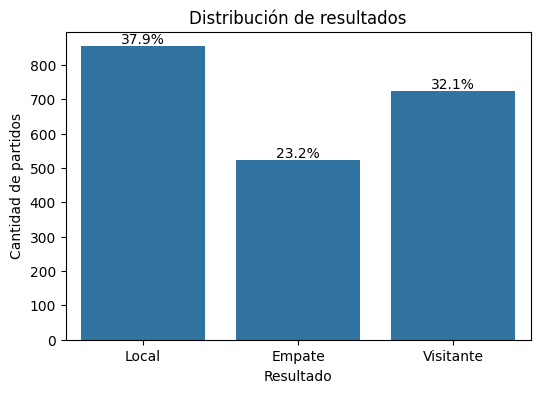

In [207]:
# Gráfico de barras con la distribución de resultados (Local, Empate, Visitante).
# Cada barra muestra la cantidad de partidos y se anota el porcentaje sobre el total.
plt.figure(figsize=(6,4))
ax = sns.countplot(
    x="Resultado",
    data=df_fixtures_gold,
    order=["Local", "Empate", "Visitante"]
)

# Calcular proporciones
total = len(df_fixtures_gold)
for p in ax.patches:
    height = p.get_height()
    porcentaje = f'{100*height/total:.1f}%'
    ax.annotate(porcentaje,
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Distribución de resultados")
plt.xlabel("Resultado")
plt.ylabel("Cantidad de partidos")
plt.show()

In [208]:
# Total de goles (suma de la columna derivada total_goals)
goles_totales = df_fixtures_gold["total_goals"].sum()
print(f"Goles totales: {goles_totales}")

Goles totales: 6110


In [209]:
# Estadísticas generales
print("Goles totales por partido")
print(f"Media: {df_fixtures_gold['total_goals'].mean():.2f}")
print(f"Mediana: {df_fixtures_gold['total_goals'].median():.2f}")
print(f"Desvío estándar: {df_fixtures_gold['total_goals'].std():.2f}")

Goles totales por partido
Media: 2.91
Mediana: 3.00
Desvío estándar: 1.81


In [210]:
# Estadísticas por condición
print("Goles de local:")
print(f"Media: {df_fixtures_gold['goals_home'].mean():.2f}")
print(f"Mediana: {df_fixtures_gold['goals_home'].median():.2f}")
print(f"Desvío estándar: {df_fixtures_gold['goals_home'].std():.2f}")

print("\nGoles de visitante:")
print(f"Media: {df_fixtures_gold['goals_away'].mean():.2f}")
print(f"Mediana: {df_fixtures_gold['goals_away'].median():.2f}")
print(f"Desvío estándar: {df_fixtures_gold['goals_away'].std():.2f}")

Goles de local:
Media: 1.54
Mediana: 1.00
Desvío estándar: 1.39

Goles de visitante:
Media: 1.37
Mediana: 1.00
Desvío estándar: 1.32


C:\Users\elias\AppData\Local\Temp\ipykernel_24732\4252040721.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Local", "Visitante"], y=[goles_local, goles_visitante], palette="pastel")


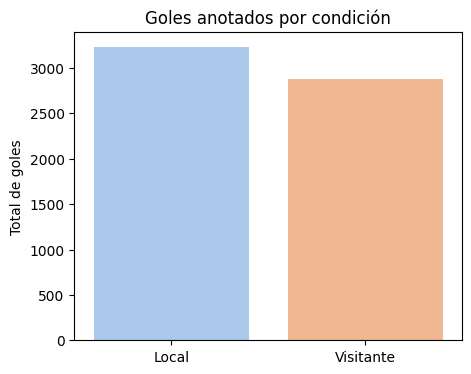

In [211]:
# Métrica: Goles convertidos por equipos locales vs visitantes
goles_local = df_fixtures_gold["goals_home"].sum()
goles_visitante = df_fixtures_gold["goals_away"].sum()

plt.figure(figsize=(5,4))
sns.barplot(x=["Local", "Visitante"], y=[goles_local, goles_visitante], palette="pastel")
plt.title("Goles anotados por condición")
plt.ylabel("Total de goles")
plt.show()

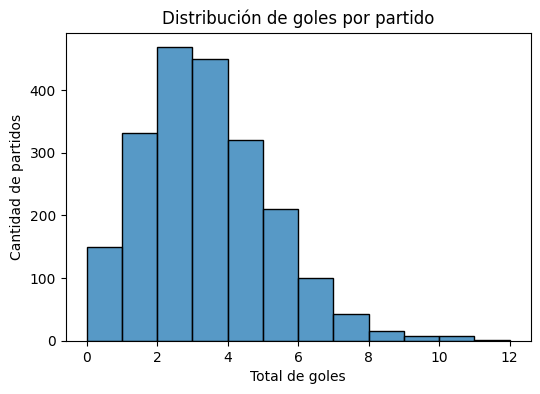

In [212]:
# Histograma de goles por partido (columna total_goals ya creada en Silver)
plt.figure(figsize=(6,4))
sns.histplot(
    df_fixtures_gold["total_goals"],
    bins=range(0, df_fixtures_gold["total_goals"].max() + 2),
    kde=False
)
plt.title("Distribución de goles por partido")
plt.xlabel("Total de goles")
plt.ylabel("Cantidad de partidos")
plt.show()

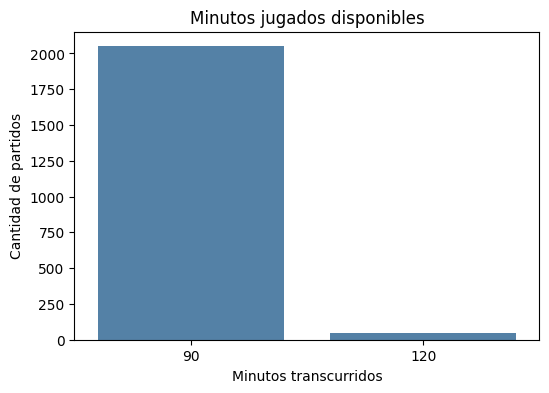

In [213]:
# Conteo agrupado de minutos jugados
conteo_minutos = df_fixtures_gold["fixture_status_elapsed"].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=conteo_minutos.index, y=conteo_minutos.values, color="steelblue")
plt.title("Minutos jugados disponibles")
plt.xlabel("Minutos transcurridos")
plt.ylabel("Cantidad de partidos")
plt.show()

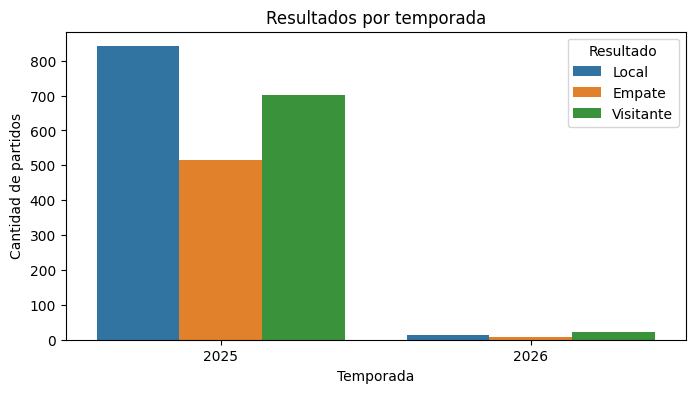

In [214]:
# Métrica: Distribución de resultados por temporada
plt.figure(figsize=(8,4))
sns.countplot(
    x="league_season",
    hue="Resultado",
    data=df_fixtures_gold,
    order=sorted(df_fixtures_gold["league_season"].unique()),
    hue_order=["Local", "Empate", "Visitante"]  # orden personalizado
)
plt.title("Resultados por temporada")
plt.xlabel("Temporada")
plt.ylabel("Cantidad de partidos")
plt.legend(title="Resultado")
plt.show()

## 6.4 Análisis de ventanas temporales (filtros por fecha)

Se deja disponible el código para aplicar filtros por rango de fechas sobre la columna *event_date*. 
Esto permite enfocar los análisis en períodos específicos, como semanas, meses o temporadas, cuando se requiera segmentar el histórico acumulado.

In [215]:
mask = (df_fixtures_gold["event_date"] >= "2025-09-01") & (df_fixtures_gold["event_date"] <= "2025-09-30")
df_fixtures_gold_filtered = df_fixtures_gold.loc[mask].copy()
df_fixtures_gold_filtered.head(3)

,fixture_id,fixture_date,fixture_periods_first,fixture_venue_id,fixture_venue_name,fixture_venue_city,fixture_status_short,fixture_status_elapsed,league_id,league_name,league_country,league_season,league_round,league_standings,teams_home_id,teams_home_name,teams_away_id,teams_away_name,goals_home,goals_away,score_halftime_home,score_halftime_away,score_fulltime_home,score_fulltime_away,score_extratime_home,score_extratime_away,score_penalty_home,score_penalty_away,event_date,match_winner,total_goals,Resultado
0,1438842,2025-09-24 00:00:00+00:00,2025-09-24 00:00:00+00:00,3905,Hasely Crawford Stadium,Port of Spain,FT,90,856,CONCACAF Caribbean Club Championship,World,2025,Group Stage - 4,False,8005,Central,3442,Mount Pleasant Academy,0,2,0,0,0,2,<NA>,<NA>,<NA>,<NA>,2025-09-24 00:00:00+00:00,Away,2,Visitante
1,1438843,2025-09-24 00:00:00+00:00,2025-09-24 00:00:00+00:00,22458,Estadio Cibao,Santiago De Los Caballeros,FT,90,856,CONCACAF Caribbean Club Championship,World,2025,Group Stage - 4,False,4446,Juventus,8004,Cibao,0,3,0,2,0,3,<NA>,<NA>,<NA>,<NA>,2025-09-24 00:00:00+00:00,Away,3,Visitante
2,1441147,2025-09-24 00:00:00+00:00,NaT,<NA>,<NA>,<NA>,PST,<NA>,243,Liga Pro Serie B,Ecuador,2025,Relegation Round - 5,True,1983,Imbabura,25736,22 de Julio,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2025-09-24 00:00:00+00:00,NaN,<NA>,NaN


## 6.5 Capa Gold: guardado en formato Delta Lake de datos dinámicos
Se almacenan en la capa *Gold* los datos de partidos ya transformados en *Silver*, pero reducidos a un conjunto de columnas relevantes para el análisis y la visualización.  
De esta forma, se conserva un dataset más compacto y práctico para su consumo posterior.  
La verificación posterior muestra la cantidad de filas y columnas guardadas.

In [216]:
# Directorio Gold
# Contiene los datos ya listos para análisis y visualización
gold_dir = f"{datalake_root}/gold/api_football"

In [217]:
# Subcarpeta para almacenar los fixtures en Gold
fixtures_gold_dir = f"{gold_dir}/fixtures"

In [218]:
# Selección de columnas relevantes para análisis
df_fixtures_curated = df_fixtures_gold[[
    "fixture_id", "event_date", "league_id", "league_name",
    "teams_home_name", "teams_away_name",
    "goals_home", "goals_away", "match_winner",
]].copy()

In [219]:
# Se convierte 'event_date' a string (YYYY-MM-DD)
# Esto garantiza particiones limpias y uniformes en Delta Lake
df_fixtures_curated["event_date"] = pd.to_datetime(
    df_fixtures_curated["event_date"]
).dt.strftime("%Y-%m-%d")

In [220]:
# Guardado en Gold con MERGE por fixture_id y partición por event_date
save_new_data_as_delta(
    df_fixtures_curated,
    fixtures_gold_dir,
    predicate="target.fixture_id = source.fixture_id",
    partition_cols=["event_date"]
)

In [221]:
df_fixtures_curated.shape

(2254, 9)

## 6.6 *[Opcional] Exportación a CSV/Parquet*  
Además del guardado en formato Delta Lake, se deja disponible la posibilidad de exportar  
los datos curados en *Gold* a un archivo *CSV* o *Parquet*. Esto facilita su consumo en otros entornos  
donde no se trabaje con Delta Lake.

In [222]:
# Directorio de exportación (dentro del datalake)
export_dir = f"{datalake_root}/exports"

In [223]:
# Crear la carpeta 'exports' si no existe
os.makedirs(export_dir, exist_ok=True)

In [224]:
# Exportación opcional a CSV
# Se guarda una versión curada del DataFrame en formato CSV
df_fixtures_curated.to_csv(f"{export_dir}/fixtures_gold.csv", index=False)

In [225]:
# Exportación opcional a Parquet
# Se guarda también en Parquet para conservar mejor los tipos de datos
df_fixtures_curated.to_parquet(f"{export_dir}/fixtures_gold.parquet", index=False)

## Cierre del apartado 6

En esta sección se presentaron métricas y visualizaciones básicas sobre los *fixtures* disponibles: 
resultados (local, empate, visitante), goles totales y promedio, distribución de goles por partido, 
minutos jugados y comparación de goles entre equipos locales y visitantes.

El objetivo de este análisis no es profundizar en estadísticas deportivas, 
sino demostrar que los datos procesados en la capa *Gold* son utilizables para generar 
insights simples. El foco principal del proyecto está en la construcción del pipeline 
de extracción, transformación y almacenamiento en Delta Lake.